In [61]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [62]:
from google.colab import files
uploaded = files.upload()

Saving airline-passengers.csv to airline-passengers (1).csv


In [63]:
df = pd.read_csv('airline-passengers.csv')

In [64]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [66]:
#adjusting df to create a new column called Date
df['datetime'] = pd.to_datetime(df['Month'])

In [67]:
df.head()

,Month,Passengers,datetime
0,1949-01,112,1949-01-01
1,1949-02,118,1949-02-01
2,1949-03,132,1949-03-01
3,1949-04,129,1949-04-01
4,1949-05,121,1949-05-01


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    object        
 1   Passengers  144 non-null    int64         
 2   datetime    144 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.5+ KB


Text(0.5, 1.0, 'Boarding Passengers')

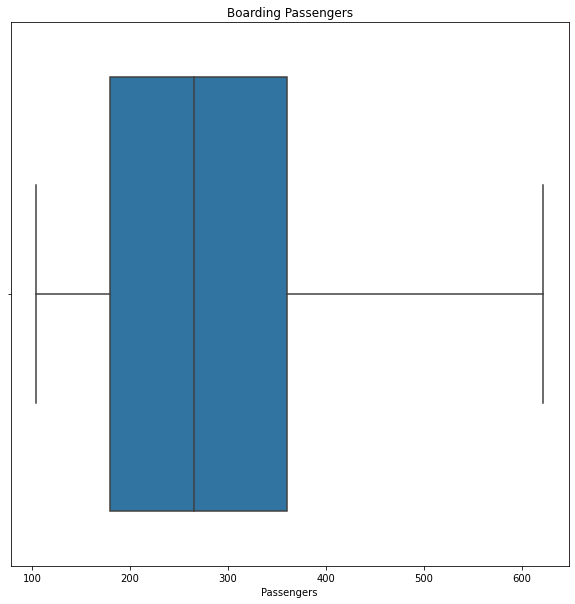

In [69]:
#checking outliers
plt.figure(figsize=(10,10))
g = sns.boxplot(df['Passengers'])
g.set_title('Boarding Passengers')

Text(0, 0.5, 'Qty of passengers')

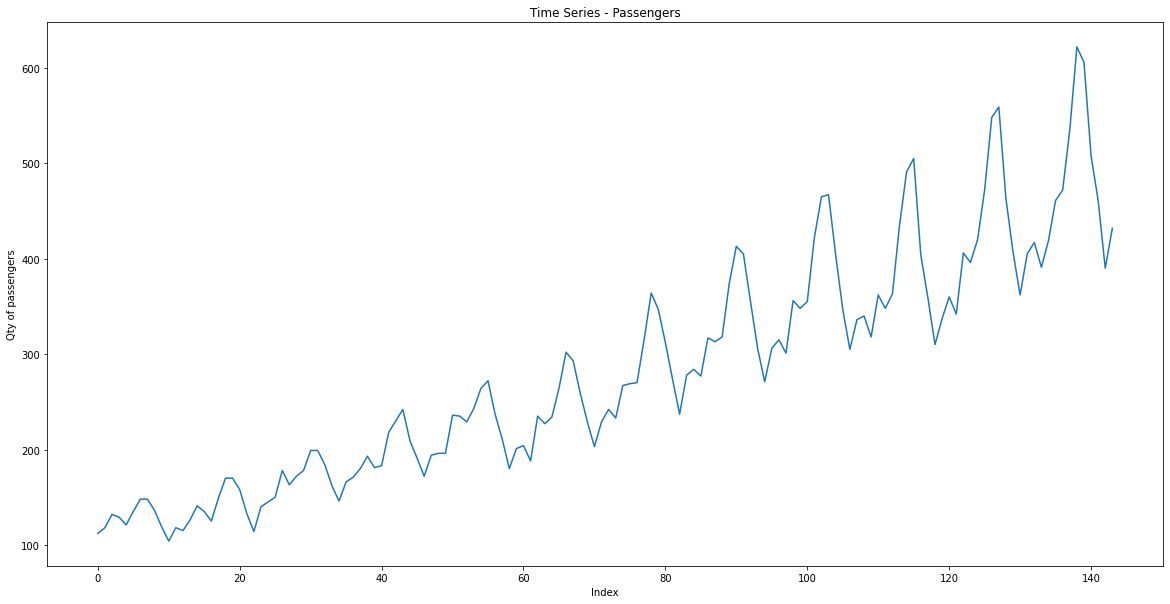

In [70]:
#plotting time series 
plt.figure(figsize=(20,10))
g = sns.lineplot(x=df.index, y=df['Passengers'])
g.set_title('Time Series - Passengers')
g.set_xlabel('Index')
g.set_ylabel('Qty of passengers')

In [71]:
#making time series decomposing

from statsmodels.tsa.seasonal import seasonal_decompose

In [72]:
#seting index as a datetime 
df_ts = df.set_index('datetime')

In [73]:
#checking and conforming columns
df_ts.columns

Index(['Month', 'Passengers'], dtype='object')

In [74]:
#removing unecessary column
df_ts.drop('Month', axis=1, inplace=True)

In [75]:
#checking df again
df_ts.head()

,Passengers
datetime,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [76]:
#making decomposing = aditive

decomp_adi = seasonal_decompose(df_ts, model='aditive', extrapolate_trend='freq')

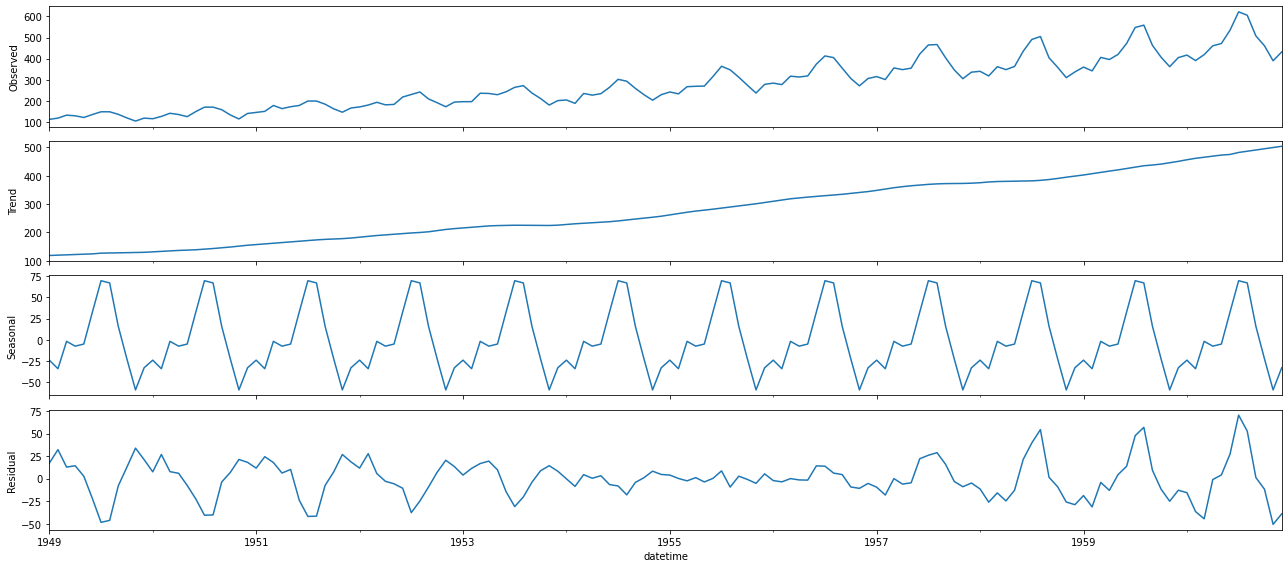

In [77]:
#making plot decomposing

from pylab import rcParams
rcParams['figure.figsize'] = 18,8
fig = decomp_adi.plot()
plt.savefig('ts_decompose.png')
plt.show()

In [78]:
#applyiin adfuller testing to verify stationarity
from statsmodels.tsa.stattools import adfuller 


In [79]:
adf_test = adfuller(df_ts.Passengers.values, autolag='AIC')
print('ADF P-Value: ', adf_test[1])
#https://medium.com/data-science-in-your-pocket/adfuller-test-intuitive-explanation-for-checking-time-series-stationarity-1e37ce6d240e
# if p-value > 0.05, the hypothesis is not rejected

ADF P-Value:  0.991880243437641


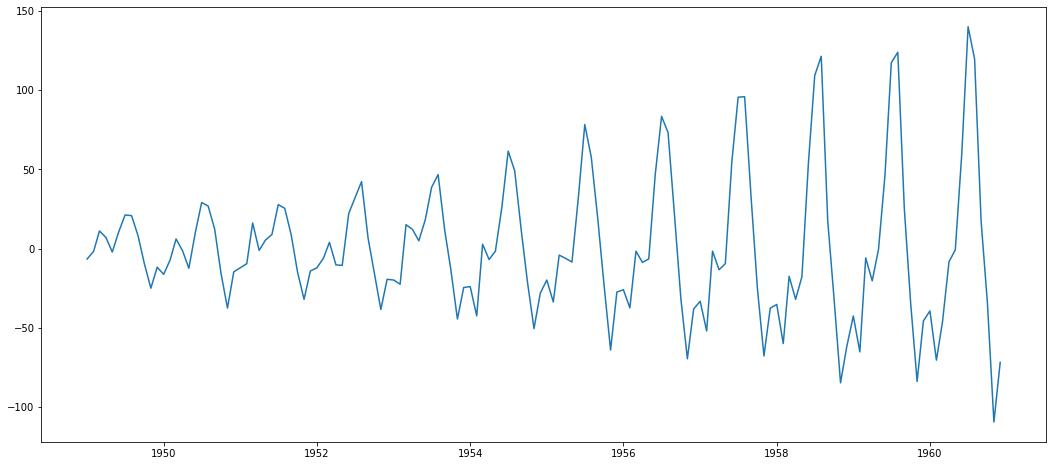

In [80]:
#removing trend from time series
detrended = df_ts - decomp_adi.trend
plt.plot(detrended)

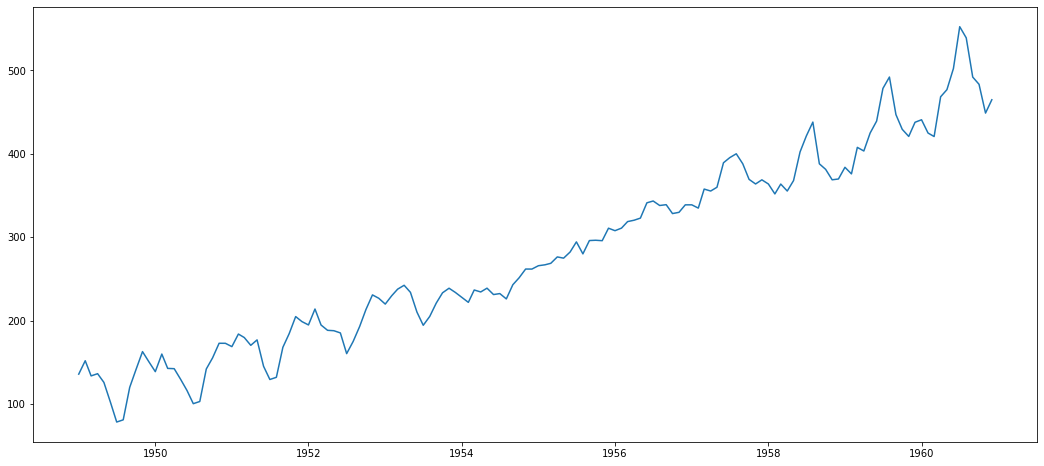

In [81]:
#removing sasonality
deseasonalized = df_ts - decomp_adi.seasonal
plt.plot(deseasonalized)

In [82]:
#making autocorrelation analysis

from statsmodels.graphics.tsaplots import plot_acf

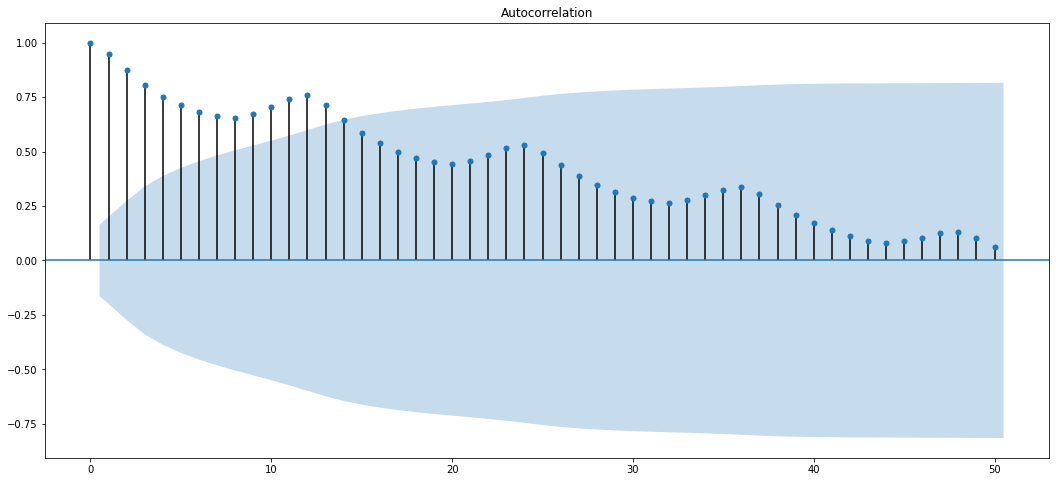

In [83]:
plot_acf(df_ts,lags=50) #applying autocorrelations
plt.savefig('lags.png')
plt.show()

The chart above, show a significant correlation with lag = 14

# Applying Recurrent Networks in Time Series

In [84]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [85]:
#converting dataset to array format
arr_pass = df_ts['Passengers'].values


In [86]:
#applying normalization
#it helps model have a more predictable behavior
scaler = MinMaxScaler(feature_range=(0,1)) #
dataset = scaler.fit_transform(arr_pass.reshape(-1,1)) #apply the scale

In [87]:
print(dataset[0:20])

[[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984556]
 [0.08494208]
 [0.08494208]
 [0.06177606]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123552]
 [0.04247104]
 [0.07142857]
 [0.05984556]
 [0.04054054]
 [0.08687259]
 [0.12741313]
 [0.12741313]]


In [88]:
#split train test data
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train),len(test))

96 48


In [89]:
#create matriz for data entry
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset) - look_back-1):
    a=dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return numpy.array(dataX), numpy.array(dataY)

In [90]:
#create shape for data entry
look_back = 14
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = numpy.reshape(trainX,(trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX,(testX.shape[0], 1, testX.shape[1]))

In [91]:
trainX.shape

(81, 1, 14)

In [92]:
#create the Recurrent Network + LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [93]:
#show network archtecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 304       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 309
Trainable params: 309
Non-trainable params: 0
_________________________________________________________________


In [94]:
#execute trainning 
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
81/81 - 0s - loss: 0.0440
Epoch 2/100
81/81 - 0s - loss: 0.0105
Epoch 3/100
81/81 - 0s - loss: 0.0070
Epoch 4/100
81/81 - 0s - loss: 0.0061
Epoch 5/100
81/81 - 0s - loss: 0.0054
Epoch 6/100
81/81 - 0s - loss: 0.0049
Epoch 7/100
81/81 - 0s - loss: 0.0044
Epoch 8/100
81/81 - 0s - loss: 0.0041
Epoch 9/100
81/81 - 0s - loss: 0.0038
Epoch 10/100
81/81 - 0s - loss: 0.0035
Epoch 11/100
81/81 - 0s - loss: 0.0034
Epoch 12/100
81/81 - 0s - loss: 0.0031
Epoch 13/100
81/81 - 0s - loss: 0.0030
Epoch 14/100
81/81 - 0s - loss: 0.0028
Epoch 15/100
81/81 - 0s - loss: 0.0027
Epoch 16/100
81/81 - 0s - loss: 0.0026
Epoch 17/100
81/81 - 0s - loss: 0.0025
Epoch 18/100
81/81 - 0s - loss: 0.0022
Epoch 19/100
81/81 - 0s - loss: 0.0021
Epoch 20/100
81/81 - 0s - loss: 0.0020
Epoch 21/100
81/81 - 0s - loss: 0.0019
Epoch 22/100
81/81 - 0s - loss: 0.0018
Epoch 23/100
81/81 - 0s - loss: 0.0017
Epoch 24/100
81/81 - 0s - loss: 0.0017
Epoch 25/100
81/81 - 0s - loss: 0.0016
Epoch 26/100
81/81 - 0s - loss: 0.

In [95]:
#making prediction
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [96]:
#return data on original format

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [97]:
#formating data for forecast

trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:,:] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

#shift for testing data

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:,:] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1,:] = testPredict

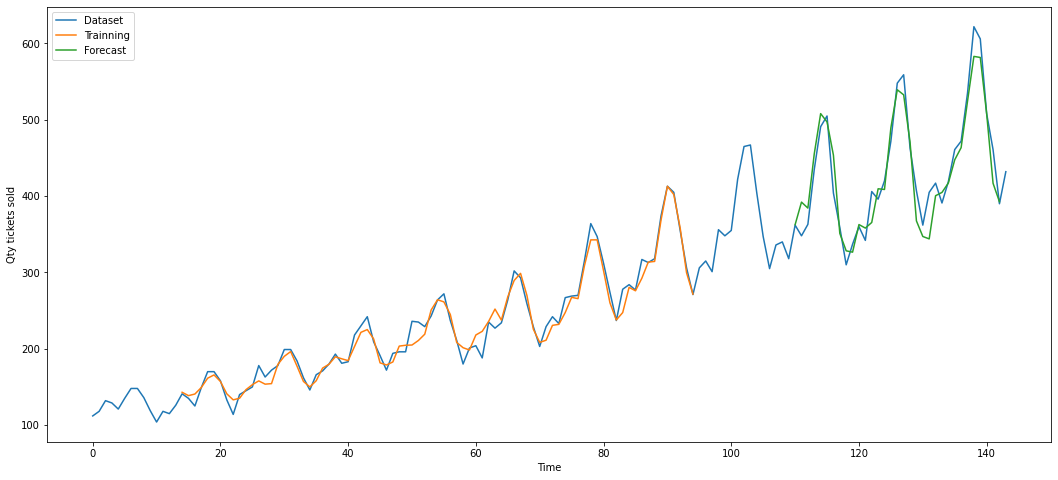

In [98]:
#plotting forecast
plt.plot(scaler.inverse_transform(dataset), label='Dataset')
plt.plot(trainPredictPlot, label='Trainning')
plt.plot(testPredictPlot, label='Forecast')
plt.xlabel('Time')
plt.ylabel('Qty tickets sold')
plt.legend()
plt.savefig('forecast.png')
plt.show()

In [99]:
y = testY[0,:]
pred = testPredict[:,]

In [100]:
# quality metrics

print('MSE = ', mean_squared_error(y,pred))
print('MAE = ', median_absolute_error(y,pred))

MSE =  603.5787546153208
MAE =  14.882720947265625
